# VidyaVichar — Code Similarity Analysis (Notebook)

This notebook contains the full pipeline for preprocessing MERN projects, 
computing multiple similarity metrics, and visualizing results.
Sections are organized for easy execution and iteration.


## 0 — Imports & Setup


In [1]:
# PART 0: IMPORTS AND SETUP
import os
import re
import json
import hashlib
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from difflib import SequenceMatcher
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


## A — Preprocessing & Data Understanding
Defines `CodePreprocessor` and `ProjectAnalyzer` to walk projects, remove comments,
normalize code, and gather metrics.


In [2]:
class CodePreprocessor:
    """Handles preprocessing of MERN stack code files"""
    
    def __init__(self, base_dir):
        self.base_dir = Path(base_dir)
        self.valid_extensions = ['.js', '.jsx', '.json', '.css']
        
    def remove_comments(self, code, file_ext):
        """Remove single-line and multi-line comments"""
        if file_ext in ['.js', '.jsx']:
            code = re.sub(r'//.*?$', '', code, flags=re.MULTILINE)
            code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
        elif file_ext == '.css':
            code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
        return code
    
    def normalize_code(self, code):
        code = re.sub(r'\s+', ' ', code)
        return code.strip()
    
    def is_minified(self, code, threshold=1000):
        lines = code.split('\n')
        avg_line_length = sum(len(line) for line in lines) / max(len(lines), 1)
        return avg_line_length > threshold
    
    def read_file(self, filepath):
        try:
            return filepath.read_text(encoding='utf-8')
        except:
            try:
                return filepath.read_text(encoding='latin-1')
            except:
                return ""

    def preprocess_file(self, filepath):
        content = self.read_file(filepath)
        if not content:
            return ""

        ext = filepath.suffix
        if self.is_minified(content):
            return ""

        content = self.remove_comments(content, ext)
        content = self.normalize_code(content)
        return content

    def analyze_project(self, project_path):
        """Analyze a single project and extract metrics"""
        project_path = Path(project_path)
        
        metrics = {
            'project_name': project_path.name,
            'total_files': 0,
            'js_files': 0,
            'jsx_files': 0,
            'json_files': 0,
            'css_files': 0,
            'total_loc': 0,
            'react_components': 0,
            'express_routes': 0,
            'mongoose_models': 0,
            'file_contents': {}
        }
        
        # Walk through project directory
        for root, dirs, files in os.walk(project_path):
            # Skip node_modules and build directories
            dirs[:] = [d for d in dirs if d not in ['node_modules', 'build', 'dist', '.git']]
            
            for file in files:
                filepath = Path(root) / file
                ext = filepath.suffix
                
                if ext in self.valid_extensions:
                    metrics['total_files'] += 1
                    
                    # Count by extension
                    if ext == '.js':
                        metrics['js_files'] += 1
                    elif ext == '.jsx':
                        metrics['jsx_files'] += 1
                    elif ext == '.json':
                        metrics['json_files'] += 1
                    elif ext == '.css':
                        metrics['css_files'] += 1
                    
                    # Preprocess and analyze content
                    content = self.preprocess_file(filepath)
                    if content:
                        # Count lines of code
                        # --- FIX: compute LOC from original file text (with comments removed)
                        # to preserve real line breaks rather than using the normalized text
                        raw = self.read_file(filepath)
                        if raw:
                            raw_no_comments = self.remove_comments(raw, ext)
                            loc = len([line for line in raw_no_comments.splitlines() if line.strip()])
                        else:
                            loc = 0
                        metrics['total_loc'] += loc
                        
                        # Detect React components
                        if ext in ['.js', '.jsx']:
                            if re.search(r'(class\s+\w+\s+extends\s+React\.Component|function\s+\w+\s*\([^)]*\)\s*{.*return.*<)', content):
                                metrics['react_components'] += 1
                            
                            # Detect Express routes
                            if re.search(r'(app|router)\.(get|post|put|delete|patch)', content):
                                metrics['express_routes'] += 1
                            
                            # Detect Mongoose models
                            if re.search(r'mongoose\.model\(|new\s+mongoose\.Schema', content):
                                metrics['mongoose_models'] += 1
                        
                        # Store relative path and content
                        rel_path = filepath.relative_to(project_path)
                        metrics['file_contents'][str(rel_path)] = content
        
        return metrics


In [3]:
class ProjectAnalyzer:
    """Analyzes multiple projects and generates summary statistics"""
    
    def __init__(self, projects_dir):
        self.projects_dir = Path(projects_dir)
        self.preprocessor = CodePreprocessor(projects_dir)
        self.projects_data = {}
    
    def analyze_all_projects(self):
        project_folders = [d for d in self.projects_dir.iterdir() if d.is_dir()]
        print(f"Found {len(project_folders)} projects...")
        
        for project in project_folders:
            print(f"Analyzing: {project.name}")
            metrics = self.preprocessor.analyze_project(project)
            self.projects_data[project.name] = metrics
            print(f"  - Files: {metrics['total_files']}, LOC: {metrics['total_loc']}")
        
        return self.projects_data

    def generate_summary_df(self):
        return pd.DataFrame([
            {
                'Project': name,
                'Total Files': m['total_files'],
                'JS Files': m['js_files'],
                'JSX Files': m['jsx_files'],
                'JSON Files': m['json_files'],
                'CSS Files': m['css_files'],
                'Total LOC': m['total_loc'],
                'React Components': m['react_components'],
                'Express Routes': m['express_routes'],
                'Mongoose Models': m['mongoose_models'],
            }
            for name, m in self.projects_data.items()
        ])



## B — Similarity Computation
Textual, structural, and semantic similarity implementations.


In [4]:
class TextualSimilarity:
    """Computes textual similarity using various metrics"""
    
    @staticmethod
    def levenshtein_similarity(a, b):
        return SequenceMatcher(None, a, b).ratio()

    @staticmethod
    def tfidf_cosine_similarity(docs):
        if len(docs) < 2:
            return np.array([[1.0]])
        try:
            vec = TfidfVectorizer(analyzer='char', ngram_range=(3,5), max_features=5000)
            tfidf = vec.fit_transform(docs)
            return cosine_similarity(tfidf)
        except:
            return np.eye(len(docs))

    @staticmethod
    def jaccard_similarity(a, b):
        s1, s2 = set(a.split()), set(b.split())
        if not s1 and not s2: return 1.0
        if not s1 or not s2: return 0.0
        return len(s1 & s2) / len(s1 | s2)


In [5]:
class StructuralSimilarity:
    """Computes structural similarity based on code structure"""

    @staticmethod
    def extract_structure(code):
        features = {
            'functions': len(re.findall(r'function\s+\w+|const\s+\w+\s*=\s*\([^)]*\)\s*=>', code)),
            'classes': len(re.findall(r'class\s+\w+', code)),
            'imports': len(re.findall(r'import\s+.*from|require\(', code)),
            'exports': len(re.findall(r'export\s+(default|const|function|class)', code)),
            'async_functions': len(re.findall(r'async\s+function|async\s+\([^)]*\)\s*=>', code)),
            'try_catch': len(re.findall(r'try\s*{', code)),
            'conditionals': len(re.findall(r'if\s*\(', code)),
            'loops': len(re.findall(r'(for|while)\s*\(', code)),
        }
        return features

    @staticmethod
    def compare_structures(features1, features2):
        """Compare two feature dictionaries"""
        all_keys = set(features1.keys()).union(set(features2.keys()))
        differences = []

        for key in all_keys:
            v1 = features1.get(key, 0)
            v2 = features2.get(key, 0)
            m = max(v1, v2)
            if m > 0:
                differences.append(abs(v1 - v2) / m)
            else:
                differences.append(0)

        return 1 - (sum(differences) / len(differences)) if differences else 1.0

    @staticmethod
    def extract_api_routes(code):
        routes = re.findall(r'(app|router)\.(get|post|put|delete|patch)\s*\(\s*[\'"]([^\'"]+)', code)
        return set(route[2] for route in routes)

    @staticmethod
    def extract_mongoose_schemas(code):
        schema_blocks = re.findall(
            r'new\s+mongoose\.Schema\s*\(\s*{([^}]+)}', code, re.DOTALL
        )
        fields = set()
        for block in schema_blocks:
            names = re.findall(r'(\w+)\s*:', block)
            fields.update(names)
        return fields



In [6]:
class SemanticSimilarity:
    """Computes semantic similarity using simple hashed embeddings"""

    @staticmethod
    def simple_code_embedding(code, embedding_dim=100):
        tokens = re.findall(r'\w+', code.lower())
        embedding = np.zeros(embedding_dim)

        for token in set(tokens[:embedding_dim]):
            h = int(hashlib.md5(token.encode()).hexdigest(), 16)
            embedding[h % embedding_dim] += tokens.count(token)

        norm = np.linalg.norm(embedding)
        if norm > 0:
            embedding = embedding / norm

        return embedding

    @staticmethod
    def compute_semantic_similarity(a, b):
        v1 = SemanticSimilarity.simple_code_embedding(a)
        v2 = SemanticSimilarity.simple_code_embedding(b)
        score = np.dot(v1, v2)
        return max(0, min(1, score))  # clamp to [0,1]


In [7]:
class SimilarityAnalyzer:
    """Main class for computing all similarity metrics"""

    def __init__(self, projects_data):
        self.projects_data = projects_data
        self.project_names = list(projects_data.keys())
        self.n_projects = len(self.project_names)

        self.textual_similarity = np.zeros((self.n_projects, self.n_projects))
        self.structural_similarity = np.zeros((self.n_projects, self.n_projects))
        self.semantic_similarity = np.zeros((self.n_projects, self.n_projects))
        self.combined_similarity = np.zeros((self.n_projects, self.n_projects))

    def compute_all_similarities(self):
        print("\nComputing pairwise similarities...\n")

        for i, p1 in enumerate(self.project_names):
            for j, p2 in enumerate(self.project_names):

                if i == j:
                    self.textual_similarity[i][j] = 1
                    self.structural_similarity[i][j] = 1
                    self.semantic_similarity[i][j] = 1
                    self.combined_similarity[i][j] = 1
                    continue

                if i < j:
                    print(f"Comparing {p1} vs {p2}")

                    c1 = " ".join(self.projects_data[p1]["file_contents"].values())
                    c2 = " ".join(self.projects_data[p2]["file_contents"].values())

                    # Textual
                    t = TextualSimilarity.tfidf_cosine_similarity([c1, c2])[0][1]
                    self.textual_similarity[i][j] = t
                    self.textual_similarity[j][i] = t

                    # Structural
                    f1 = StructuralSimilarity.extract_structure(c1)
                    f2 = StructuralSimilarity.extract_structure(c2)
                    s = StructuralSimilarity.compare_structures(f1, f2)
                    self.structural_similarity[i][j] = s
                    self.structural_similarity[j][i] = s

                    # Semantic
                    sem = SemanticSimilarity.compute_semantic_similarity(c1, c2)
                    self.semantic_similarity[i][j] = sem
                    self.semantic_similarity[j][i] = sem

                    # Weighted combination
                    combined = 0.4 * t + 0.3 * s + 0.3 * sem
                    self.combined_similarity[i][j] = combined
                    self.combined_similarity[j][i] = combined

                    print(f"  Textual: {t:.3f}, Structural: {s:.3f}, Semantic: {sem:.3f}")

        return {
            "textual": self.textual_similarity,
            "structural": self.structural_similarity,
            "semantic": self.semantic_similarity,
            "combined": self.combined_similarity,
        }




## C — Visualization & Reporting
Contains plotting utilities (heatmaps, graphs, distributions).


In [8]:
class SimilarityVisualizer:
    """Creates visualizations for similarity analysis"""

    def __init__(self, project_names, similarity_matrices):
        self.project_names = project_names
        self.matrices = similarity_matrices

    def plot_heatmap(self, matrix_type="combined", save_path=None):
        matrix = self.matrices[matrix_type]

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            matrix,
            annot=True,
            fmt=".3f",
            cmap="YlOrRd",
            xticklabels=self.project_names,
            yticklabels=self.project_names,
            vmin=0,
            vmax=1,
            cbar_kws={"label": "Similarity Score"},
        )

        plt.title(f"{matrix_type.capitalize()} Similarity Heatmap", fontsize=16)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")

        plt.show()

    def plot_network_graph(self, matrix_type="combined", threshold=0.6, save_path=None):
        matrix = self.matrices[matrix_type]
        G = nx.Graph()

        for name in self.project_names:
            G.add_node(name)

        for i, p1 in enumerate(self.project_names):
            for j, p2 in enumerate(self.project_names):
                if i < j and matrix[i][j] > threshold:
                    G.add_edge(p1, p2, weight=matrix[i][j])

        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(G, k=2, iterations=50)

        nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=3000)
        edges = G.edges()
        weights = [G[u][v]["weight"] for u, v in edges]

        nx.draw_networkx_edges(
            G, pos, width=[w * 5 for w in weights], alpha=0.6, edge_color=weights, edge_cmap=plt.cm.Reds
        )

        nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
        plt.title(f"Project Similarity Network (threshold={threshold})", fontsize=16)
        plt.axis("off")
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")

        plt.show()

    def plot_similarity_comparison(self, save_path=None):
        metrics = ["textual", "structural", "semantic", "combined"]
        values = []

        for m in metrics:
            matrix = self.matrices[m]
            upper = matrix[np.triu_indices_from(matrix, k=1)]
            values.append(np.mean(upper))

        plt.figure(figsize=(10, 6))
        bars = plt.bar(metrics, values)

        for bar in bars:
            h = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., h, f"{h:.3f}",
                     ha="center", va="bottom")

        plt.ylim(0, 1)
        plt.grid(axis="y", alpha=0.3)
        plt.title("Average Similarity by Metric", fontsize=16)

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")

        plt.show()

    def plot_distribution(self, matrix_type="combined", save_path=None):
        matrix = self.matrices[matrix_type]
        upper = matrix[np.triu_indices_from(matrix, k=1)]

        plt.figure(figsize=(10, 6))
        plt.hist(upper, bins=20, alpha=0.7, edgecolor="black")

        plt.axvline(np.mean(upper), color="red", linestyle="--", linewidth=2,
                    label=f"Mean: {np.mean(upper):.3f}")
        plt.axvline(np.median(upper), color="green", linestyle="--", linewidth=2,
                    label=f"Median: {np.median(upper):.3f}")

        plt.title(f"{matrix_type.capitalize()} Similarity Distribution", fontsize=16)
        plt.xlabel("Similarity Score")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(axis="y", alpha=0.3)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")

        plt.show()






## D — Main Execution Pipeline
The `main()` function runs the full pipeline:
- Preprocessing
- Similarity computation
- Saving CSVs
- Generating plots
- Producing summary insights


In [9]:
def main(projects_directory='./projects'):
    """Main execution pipeline"""
    
    print("="*70)
    print("VidyaVichar Code Similarity Analysis")
    print("="*70)
    
    # Create results directory
    results_dir = Path('./results')
    results_dir.mkdir(exist_ok=True)
    
    # ========================================================================
    # PART A: Preprocessing & Data Understanding
    # ========================================================================
    print("\n" + "="*70)
    print("PART A: PREPROCESSING & DATA UNDERSTANDING")
    print("="*70)
    
    analyzer = ProjectAnalyzer(projects_directory)
    projects_data = analyzer.analyze_all_projects()
    
    # Generate summary
    summary_df = analyzer.generate_summary_df()
    print("\n" + summary_df.to_string(index=False))
    
    # Save summary
    summary_df.to_csv(results_dir / 'preprocessing_summary.csv', index=False)
    print(f"\n✓ Summary saved to {results_dir / 'preprocessing_summary.csv'}")
    
    # ========================================================================
    # PART B: Code Similarity Computation
    # ========================================================================
    print("\n" + "="*70)
    print("PART B: CODE SIMILARITY COMPUTATION")
    print("="*70)
    
    sim_analyzer = SimilarityAnalyzer(projects_data)
    similarity_matrices = sim_analyzer.compute_all_similarities()
    
    # Save similarity matrices
    for metric, matrix in similarity_matrices.items():
        matrix_df = pd.DataFrame(
            matrix,
            index=sim_analyzer.project_names,
            columns=sim_analyzer.project_names
        )
        matrix_df.to_csv(results_dir / f'{metric}_similarity_matrix.csv')
        print(f"✓ {metric.capitalize()} similarity matrix saved")
    
    # ========================================================================
    # PART C: Visualization & Reporting
    # ========================================================================
    print("\n" + "="*70)
    print("PART C: VISUALIZATION & REPORTING")
    print("="*70)
    
    visualizer = SimilarityVisualizer(sim_analyzer.project_names, similarity_matrices)
    
    # Generate visualizations
    print("\nGenerating visualizations...")
    
    visualizer.plot_heatmap('combined', results_dir / 'heatmap_combined.png')
    visualizer.plot_heatmap('textual', results_dir / 'heatmap_textual.png')
    visualizer.plot_network_graph('combined', threshold=0.5, 
                                  save_path=results_dir / 'network_graph.png')
    visualizer.plot_similarity_comparison(results_dir / 'comparison_bar_chart.png')
    visualizer.plot_distribution('combined', results_dir / 'similarity_distribution.png')
    
    print("\n✓ All visualizations generated successfully!")
    
    # ========================================================================
    # Generate Insights Report
    # ========================================================================
    print("\n" + "="*70)
    print("KEY INSIGHTS")
    print("="*70)
    
    combined_matrix = similarity_matrices['combined']
    upper_triangle = combined_matrix[np.triu_indices_from(combined_matrix, k=1)]
    
    # Find most and least similar pairs
    max_idx = np.unravel_index(np.argmax(combined_matrix - np.eye(len(combined_matrix))), 
                                combined_matrix.shape)
    min_idx = np.unravel_index(np.argmin(combined_matrix + np.eye(len(combined_matrix)) * 2), 
                                combined_matrix.shape)
    
    print(f"\nOverall Statistics:")
    print(f"  - Average Similarity: {np.mean(upper_triangle):.3f}")
    print(f"  - Median Similarity: {np.median(upper_triangle):.3f}")
    print(f"  - Std Deviation: {np.std(upper_triangle):.3f}")
    
    print(f"\nMost Similar Projects:")
    print(f"  - {sim_analyzer.project_names[max_idx[0]]} ↔ {sim_analyzer.project_names[max_idx[1]]}")
    print(f"  - Similarity Score: {combined_matrix[max_idx]:.3f}")
    
    print(f"\nLeast Similar Projects:")
    print(f"  - {sim_analyzer.project_names[min_idx[0]]} ↔ {sim_analyzer.project_names[min_idx[1]]}")
    print(f"  - Similarity Score: {combined_matrix[min_idx]:.3f}")
    
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE!")
    print("="*70)
    print(f"\nResults saved in: {results_dir.absolute()}")
    print("\nFiles generated:")
    print("  - preprocessing_summary.csv")
    print("  - *_similarity_matrix.csv (4 files)")
    print("  - *.png (5 visualization files)")
    
    return {
        'projects_data': projects_data,
        'summary': summary_df,
        'similarity_matrices': similarity_matrices,
        'visualizer': visualizer
    }


---
### Notes & Tips
- `node_modules`, `build`, and `.git` folders are ignored automatically.
- For better semantic similarity, replace the simple hashing model with:
  - CodeBERT
  - OpenAI Code Embeddings
- All plots are saved under `./results/`.


VidyaVichar Code Similarity Analysis

PART A: PREPROCESSING & DATA UNDERSTANDING
Found 19 projects...
Analyzing: team26_vidyavichar
  - Files: 29, LOC: 4431
Analyzing: team27_vidyavichar
  - Files: 53, LOC: 5450
Analyzing: team6_vidyavichar
  - Files: 44, LOC: 7198
Analyzing: team13_vidyavichar
  - Files: 28, LOC: 25428
Analyzing: team16_vidyavichar
  - Files: 53, LOC: 5195
Analyzing: team33_vidyavichar
  - Files: 46, LOC: 2496
Analyzing: team22_vidyavichar
  - Files: 51, LOC: 29560
Analyzing: team32_vidyavichar
  - Files: 32, LOC: 21753
Analyzing: team3_vidyavichar
  - Files: 32, LOC: 7875
Analyzing: team20_vidyavichar
  - Files: 46, LOC: 10228
Analyzing: team24_vidyavichar
  - Files: 31, LOC: 3380
Analyzing: team29_vidyavichar
  - Files: 36, LOC: 20489
Analyzing: team14_vidyavichar
  - Files: 42, LOC: 12473
Analyzing: team28_vidyavichar
  - Files: 37, LOC: 21615
Analyzing: team21_vidyavichar
  - Files: 23, LOC: 18745
Analyzing: team5_vidyavichar
  - Files: 53, LOC: 14212
Analyzing: t

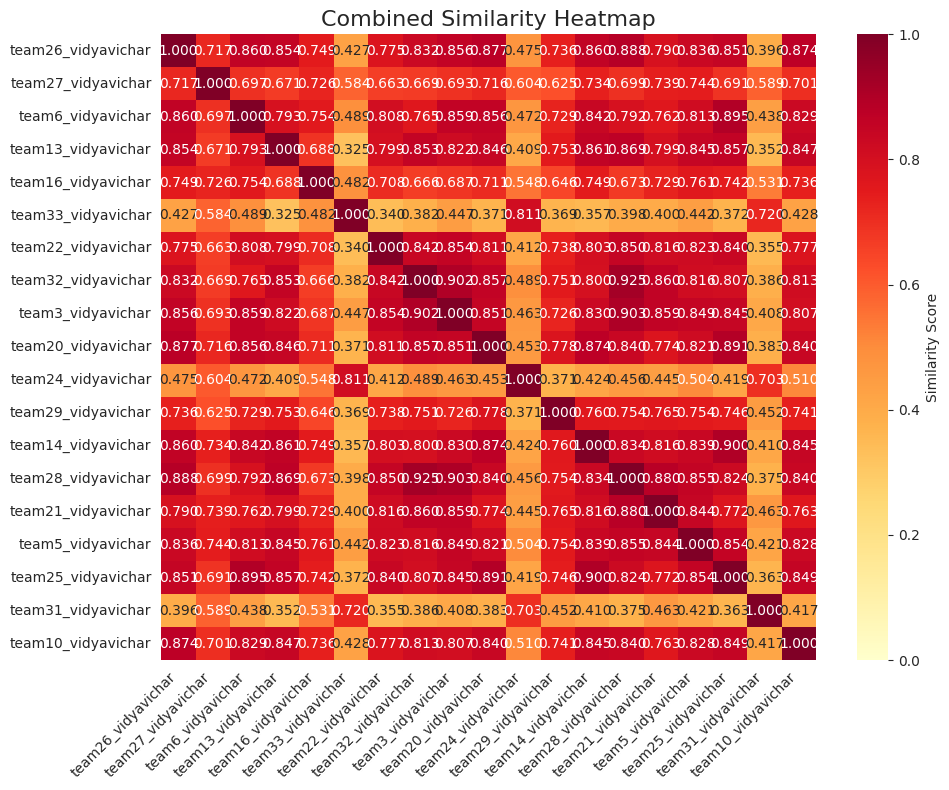

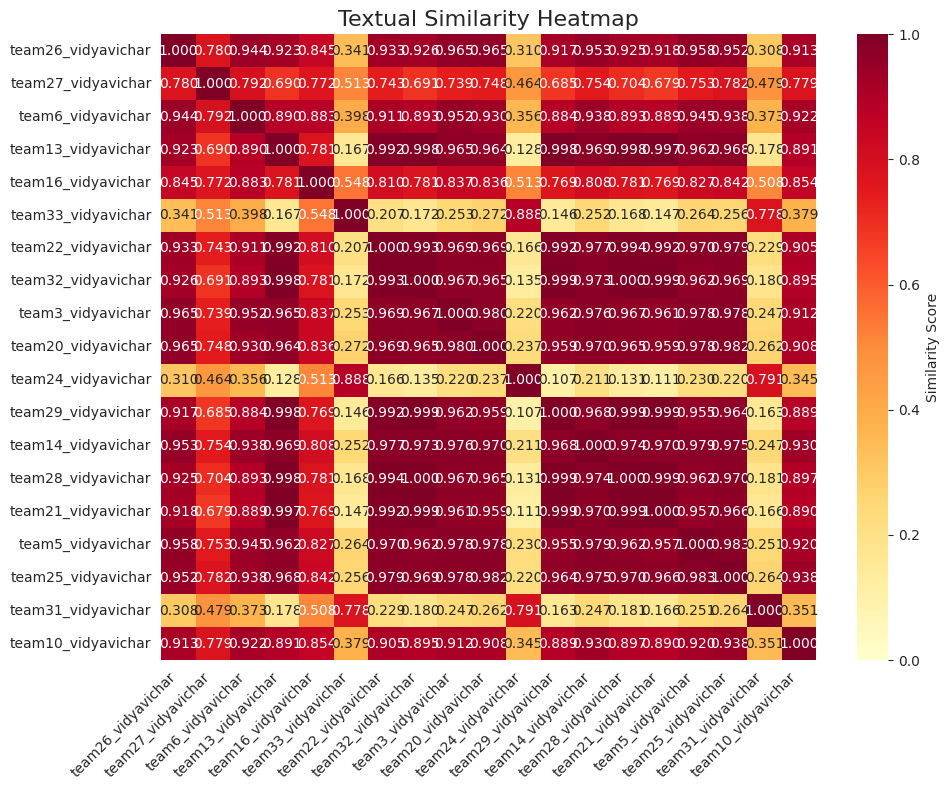

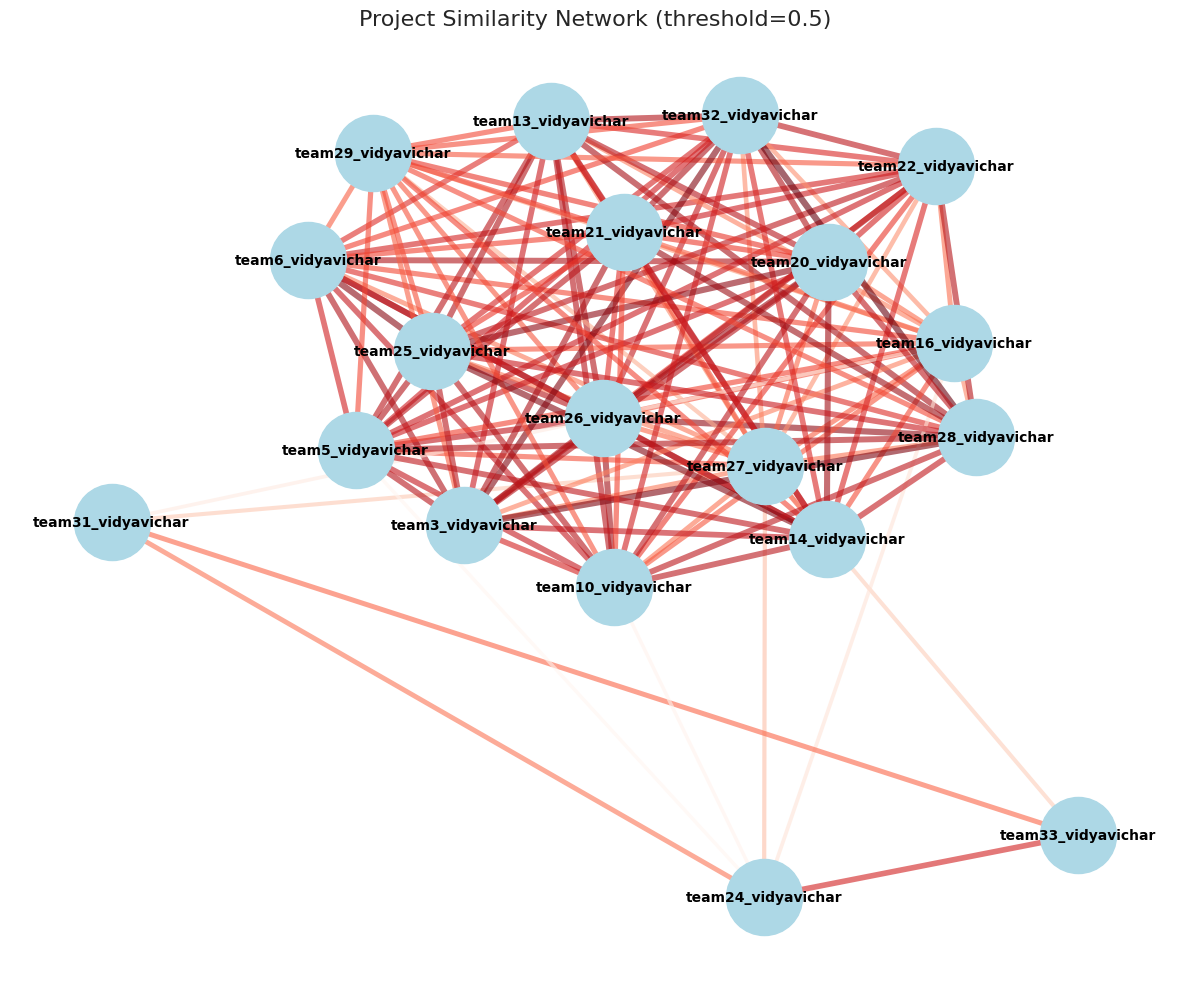

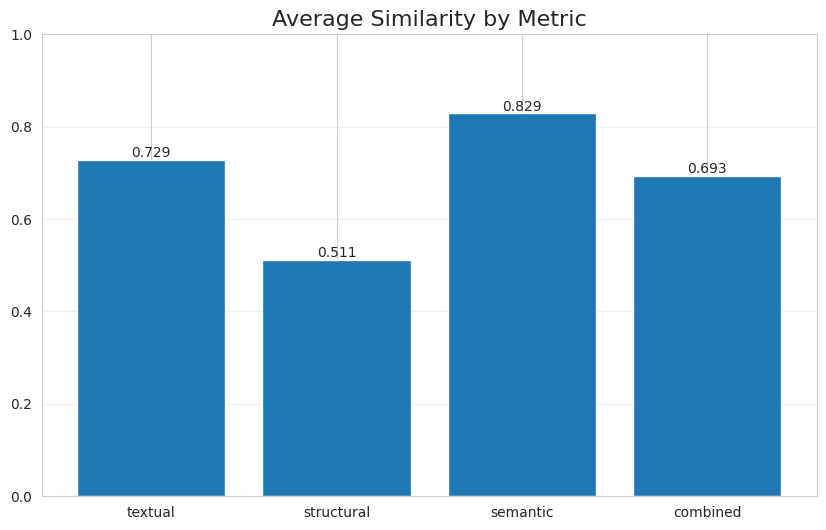

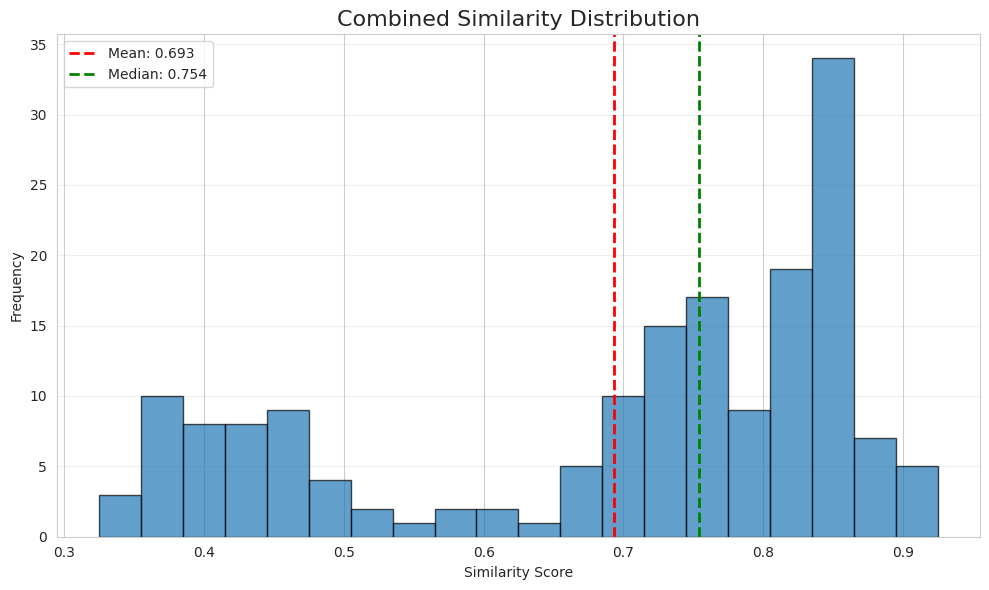


✓ All visualizations generated successfully!

KEY INSIGHTS

📊 Overall Statistics:
  - Average Similarity: 0.693
  - Median Similarity: 0.754
  - Std Deviation: 0.175

🔗 Most Similar Projects:
  - team32_vidyavichar ↔ team28_vidyavichar
  - Similarity Score: 0.925

🔀 Least Similar Projects:
  - team13_vidyavichar ↔ team33_vidyavichar
  - Similarity Score: 0.325

ANALYSIS COMPLETE!

📁 Results saved in: /home/user/Documents/Q1/results

Files generated:
  - preprocessing_summary.csv
  - *_similarity_matrix.csv (4 files)
  - *.png (5 visualization files)


In [10]:
if __name__ == "__main__":
    results = main('./projects')